---
# 
---

In this notebook

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import joblib

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.metrics import mean_squared_error

2025-04-03 11:43:38.312977: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-03 11:43:38.610207: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-03 11:43:38.905684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743695019.229269 1904716 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743695019.321566 1904716 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743695019.969270 1904716 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Define files

In [24]:
data_dir = '../data/'
model_dir = '../model/'

ghg = 'GreenHouse_Gases/processed/'

frequency = 'DLY'

climate_file = 'ECCC/processed/daily/daily_processed.csv'
#climate_file = 'ECCC/processed/monthly/monthly_processed.csv'

population_file = 'Population/processed/Montreal.csv'

co2_file = 'ch4_1850-2099_SSP2_45.csv'
ch4_file = 'co2_1850-2099_SSP2_45.csv'

scenario = 'SSP2-45'

### Define variables

**Daily**

In [3]:
Tmax = 'Max Temp (°C)'
Tmin =  'Min Temp (°C)' 
Tmean = 'Mean Temp (°C)'

cols = ['Max Temp (°C)', 'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag',
       'Mean Temp (°C)', 'Mean Temp Flag', 'Heat Deg Days (°C)',
       'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag',
       'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)',
       'Total Snow Flag', 'Total Precip (mm)', 'Total Precip Flag',
       'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)',
       'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)',
       'Spd of Max Gust Flag']

**Monthly**

### Read data files

In [4]:
co2_df = pd.read_csv(os.path.join(data_dir, ghg, co2_file), index_col=0, parse_dates=True)
co2_df

CH4
Year                   
1850-01-01   791.600000
1851-01-01   792.859068
1852-01-01   794.156502
1853-01-01   795.493289
1854-01-01   796.859405
...                 ...
2095-01-01  1698.879883
2096-01-01  1695.429810
2097-01-01  1692.139893
2098-01-01  1689.009888
2099-01-01  1686.019897

[250 rows x 1 columns]

In [5]:
ch4_df = pd.read_csv(os.path.join(data_dir, ghg, ch4_file), index_col=0, parse_dates=True)
ch4_df.drop(columns = 'Data Source', inplace=True)
ch4_df

CO2
Year                  
1850-01-01  285.200000
1851-01-01  285.100000
1852-01-01  285.000000
1853-01-01  285.000000
1854-01-01  284.900000
...                ...
2095-01-01  600.885986
2096-01-01  601.365967
2097-01-01  601.796997
2098-01-01  602.177002
2099-01-01  602.505005

[250 rows x 1 columns]

In [6]:
pop_df = pd.read_csv(os.path.join(data_dir, population_file), index_col=0, parse_dates=True)
pop_df

Population
1801-01-01  9.000000e+03
1802-01-01  9.389547e+03
1803-01-01  9.788026e+03
1804-01-01  1.019544e+04
1805-01-01  1.061293e+04
...                  ...
2095-01-01  2.258385e+06
2096-01-01  2.249969e+06
2097-01-01  2.240726e+06
2098-01-01  2.230707e+06
2099-01-01  2.219886e+06

[299 rows x 1 columns]

In [7]:
wx_df = pd.read_csv(os.path.join(data_dir, climate_file), index_col=0, parse_dates=True)
wx_df

/tmp/ipykernel_1904716/1851272773.py:1: DtypeWarning: Columns (5,11,13,15,17,19,27,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  wx_df = pd.read_csv(os.path.join(data_dir, climate_file), index_col=0, parse_dates=True)


Station  Longitude (x)  Latitude (y)  \
Date/Time                                                             
1891-10-22  Montreal (McTavish/McGill)         -73.58          45.5   
1891-10-23  Montreal (McTavish/McGill)         -73.58          45.5   
1891-10-24  Montreal (McTavish/McGill)         -73.58          45.5   
1891-10-25  Montreal (McTavish/McGill)         -73.58          45.5   
1891-10-26  Montreal (McTavish/McGill)         -73.58          45.5   
...                                ...            ...           ...   
2025-03-23  Montreal (McTavish/McGill)         -73.58          45.5   
2025-03-24  Montreal (McTavish/McGill)         -73.58          45.5   
2025-03-25  Montreal (McTavish/McGill)         -73.58          45.5   
2025-03-26  Montreal (McTavish/McGill)         -73.58          45.5   
2025-03-27  Montreal (McTavish/McGill)         -73.58          45.5   

               Station Name Climate ID  Year  Month  Day  Data Quality  \
Date/Time                                                                
1891-10-22  MONTREAL MCGILL    7025280  1891     10   22           NaN   
1891-10-23  MONTREAL MCGILL    7025280  1891     10   23           NaN   
1891-10-24  MONTREAL MCGILL    7025280  1891     10   24           NaN   
1891-10-25  MONTREAL MCGILL    7025280  1891     10   25           NaN   
1891-10-26  MONTREAL MCGILL    7025280  1891     10   26           NaN   
...                     ...        ...   ...    ...  ...           ...   
2025-03-23         MCTAVISH    7024745  2025      3   23           NaN   
2025-03-24         MCTAVISH    7024745  2025      3   24           NaN   
2025-03-25         MCTAVISH    7024745  2025      3   25           NaN   
2025-03-26         MCTAVISH    7024745  2025      3   26           NaN   
2025-03-27         MCTAVISH    7024745  2025      3   27           NaN   

            Max Temp (°C)  ... Total Snow (cm)  Total Snow Flag  \
Date/Time                  ...                                    
1891-10-22            5.6  ...             0.0                T   
1891-10-23            3.9  ...             0.0              NaN   
1891-10-24            5.0  ...             0.0              NaN   
1891-10-25            3.3  ...             0.0              NaN   
1891-10-26           10.6  ...             0.0              NaN   
...                   ...  ...             ...              ...   
2025-03-23           -1.6  ...             NaN              NaN   
2025-03-24            3.9  ...             NaN              NaN   
2025-03-25            4.5  ...             NaN              NaN   
2025-03-26            4.8  ...             NaN              NaN   
2025-03-27            7.1  ...             NaN              NaN   

           Total Precip (mm)  Total Precip Flag Snow on Grnd (cm)  \
Date/Time                                                           
1891-10-22               0.0                  T               NaN   
1891-10-23               0.0                NaN               NaN   
1891-10-24               0.0                NaN               NaN   
1891-10-25               0.0                NaN               NaN   
1891-10-26               4.1                NaN               NaN   
...                      ...                ...               ...   
2025-03-23               0.0                NaN              10.0   
2025-03-24               6.7                NaN               9.0   
2025-03-25               1.1                NaN              11.0   
2025-03-26               0.4                NaN               4.0   
2025-03-27               0.5                NaN               1.0   

            Snow on Grnd Flag Dir of Max Gust (10s deg)  Dir of Max Gust Flag  \
Date/Time                                                                       
1891-10-22                NaN                       NaN                   NaN   
1891-10-23                NaN                       NaN                   NaN   
1891-10-24                NaN                     

### Remove incomplete start and end year of climate dataset

In [8]:
tmp = wx_df.groupby(['Year']).count()

tmp[tmp['Station'] < 365]

Station  Longitude (x)  Latitude (y)  Station Name  Climate ID  Month  \
Year                                                                          
1891       71             71            71            71          71     71   
2025       86             86            86            86          86     86   

      Day  Data Quality  Max Temp (°C)  Max Temp Flag  ...  Total Snow (cm)  \
Year                                                   ...                    
1891   71             0             71              0  ...               71   
2025   86             0             86              0  ...                0   

      Total Snow Flag  Total Precip (mm)  Total Precip Flag  \
Year                                                          
1891                8                 71                 10   
2025                0                 85                  1   

      Snow on Grnd (cm)  Snow on Grnd Flag  Dir of Max Gust (10s deg)  \
Year                                                                    
1891                  0                  0                          0   
2025                 86                  0                         27   

      Dir of Max Gust Flag  Spd of Max Gust (km/h)  Spd of Max Gust Flag  
Year                                                                      
1891                     0                       0                     0  
2025                     0                      27                     0  

[2 rows x 30 columns]

In [9]:
start_wx = wx_df.index.min()
end_wx = wx_df.index.max()
print(type(start_wx), end_wx)

for year in [start_wx, end_wx] :

    nbr_days_year = 366 if pd.Period(year, freq='Y').is_leap_year else 365

    yr = int(year.strftime('%Y'))
    nbr_obs_year = tmp[tmp.index == yr]['Station'].values[0]

    print('*',yr, nbr_obs_year, '*')
    
    if nbr_obs_year != nbr_days_year :
        print(f'Not full year. Removing partial {yr} from dataframe')
        wx_df = wx_df[wx_df['Year'] != yr]

        start_wx = wx_df.index.min()
        end_wx = wx_df.index.max()
    else :
        print(f'Full year. Not removing {yr} from obs dataframe.')
    
wx_df

<class 'pandas._libs.tslibs.timestamps.Timestamp'> 2025-03-27 00:00:00
* 1891 71 *
Not full year. Removing partial 1891 from dataframe
* 2025 86 *
Not full year. Removing partial 2025 from dataframe


Station  Longitude (x)  Latitude (y)  \
Date/Time                                                             
1892-01-01  Montreal (McTavish/McGill)         -73.58          45.5   
1892-01-02  Montreal (McTavish/McGill)         -73.58          45.5   
1892-01-03  Montreal (McTavish/McGill)         -73.58          45.5   
1892-01-04  Montreal (McTavish/McGill)         -73.58          45.5   
1892-01-05  Montreal (McTavish/McGill)         -73.58          45.5   
...                                ...            ...           ...   
2024-12-27  Montreal (McTavish/McGill)         -73.58          45.5   
2024-12-28  Montreal (McTavish/McGill)         -73.58          45.5   
2024-12-29  Montreal (McTavish/McGill)         -73.58          45.5   
2024-12-30  Montreal (McTavish/McGill)         -73.58          45.5   
2024-12-31  Montreal (McTavish/McGill)         -73.58          45.5   

               Station Name Climate ID  Year  Month  Day  Data Quality  \
Date/Time                                                                
1892-01-01  MONTREAL MCGILL    7025280  1892      1    1           NaN   
1892-01-02  MONTREAL MCGILL    7025280  1892      1    2           NaN   
1892-01-03  MONTREAL MCGILL    7025280  1892      1    3           NaN   
1892-01-04  MONTREAL MCGILL    7025280  1892      1    4           NaN   
1892-01-05  MONTREAL MCGILL    7025280  1892      1    5           NaN   
...                     ...        ...   ...    ...  ...           ...   
2024-12-27         MCTAVISH    7024745  2024     12   27           NaN   
2024-12-28         MCTAVISH    7024745  2024     12   28           NaN   
2024-12-29         MCTAVISH    7024745  2024     12   29           NaN   
2024-12-30         MCTAVISH    7024745  2024     12   30           NaN   
2024-12-31         MCTAVISH    7024745  2024     12   31           NaN   

            Max Temp (°C)  ... Total Snow (cm)  Total Snow Flag  \
Date/Time                  ...                                    
1892-01-01           -5.6  ...             0.0                T   
1892-01-02            6.7  ...             0.0              NaN   
1892-01-03            2.2  ...             7.6              NaN   
1892-01-04           -7.2  ...             0.3              NaN   
1892-01-05          -12.2  ...             0.5              NaN   
...                   ...  ...             ...              ...   
2024-12-27           -6.1  ...             NaN              NaN   
2024-12-28           -1.7  ...             NaN              NaN   
2024-12-29            7.6  ...             NaN              NaN   
2024-12-30           10.6  ...             NaN              NaN   
2024-12-31            6.3  ...             NaN              NaN   

           Total Precip (mm)  Total Precip Flag Snow on Grnd (cm)  \
Date/Time                                                           
1892-01-01               0.0                  T               NaN   
1892-01-02              11.2                NaN               NaN   
1892-01-03              11.4                NaN               NaN   
1892-01-04               0.3                NaN               NaN   
1892-01-05               0.5                NaN               NaN   
...                      ...                ...               ...   
2024-12-27               0.0                NaN              11.0   
2024-12-28               0.2                NaN              11.0   
2024-12-29               5.2                NaN              11.0   
2024-12-30              10.3                NaN               5.0   
2024-12-31               0.0                NaN               1.0   

            Snow on Grnd Flag Dir of Max Gust (10s deg)  Dir of Max Gust Flag  \
Date/Time                                                                       
1892-01-01                NaN                       NaN                   NaN   
1892-01-02                NaN                       NaN                   NaN   
1892-01-03                NaN                     

### Plot the data

In [10]:
stn = wx_df['Station'].unique()[0]
stn

'Montreal (McTavish/McGill)'

/tmp/ipykernel_1904716/1294534305.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


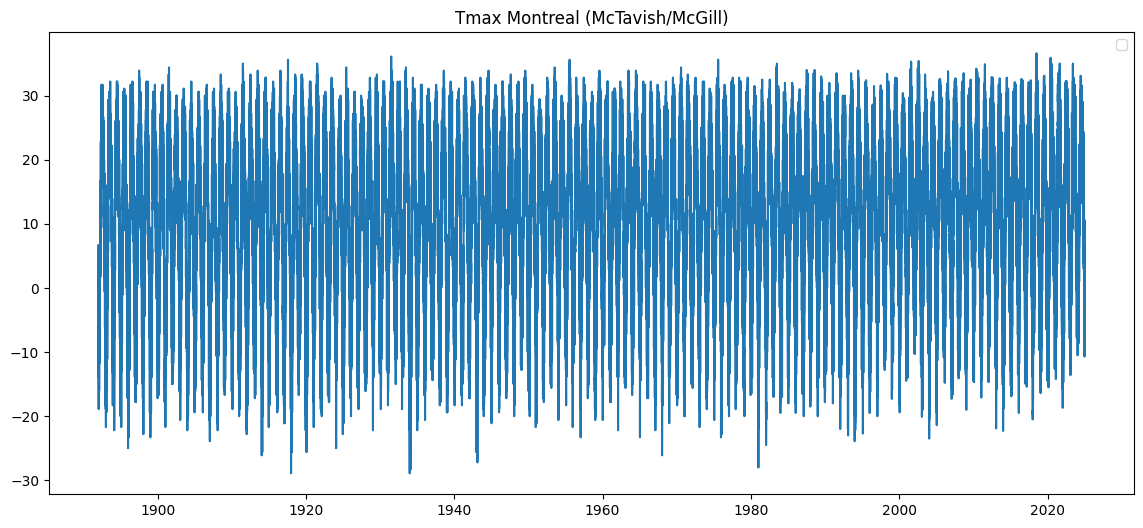

In [11]:
fig = plt.figure(figsize=(14,6))

ax = plt.plot(wx_df.index, wx_df[Tmax])

plt.title(f'Tmax {stn}')

plt.legend()

plt.show()

/tmp/ipykernel_1904716/634575607.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


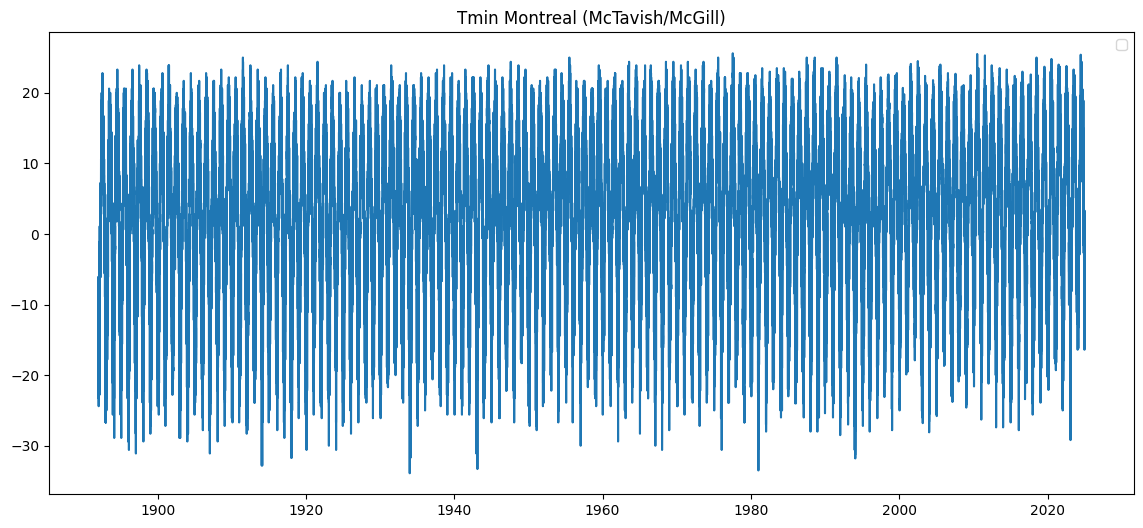

In [12]:
fig = plt.figure(figsize=(14,6))

ax = plt.plot(wx_df.index, wx_df[Tmin])

plt.title(f'Tmin {stn}')

plt.legend()

plt.show()

/tmp/ipykernel_1904716/1541288815.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


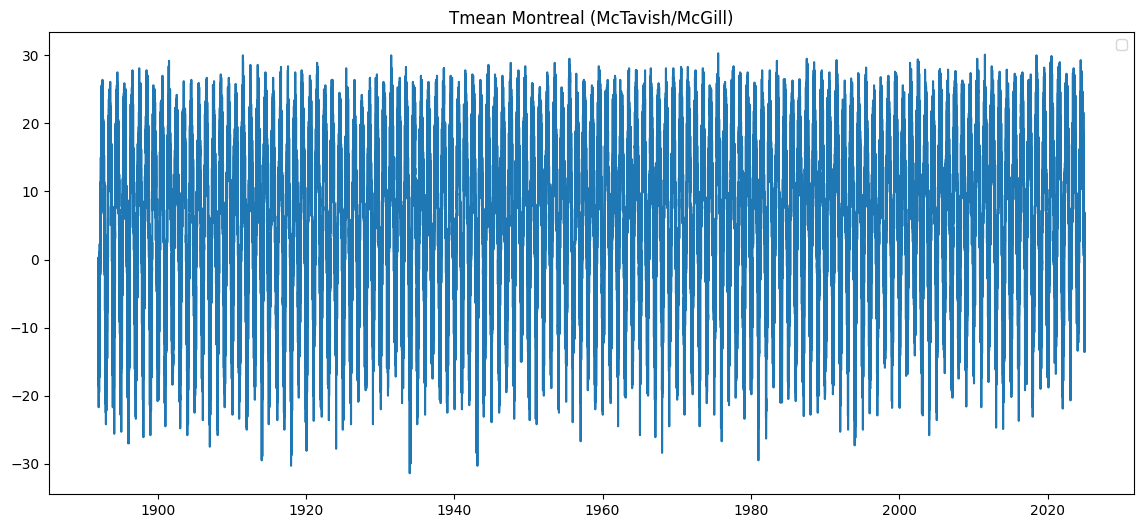

In [13]:
fig = plt.figure(figsize=(14,6))

ax = plt.plot(wx_df.index, wx_df[Tmean])

plt.title(f'Tmean {stn}')

plt.legend()

plt.show()

### Plot temperature trend by months

/tmp/ipykernel_1904716/897467635.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


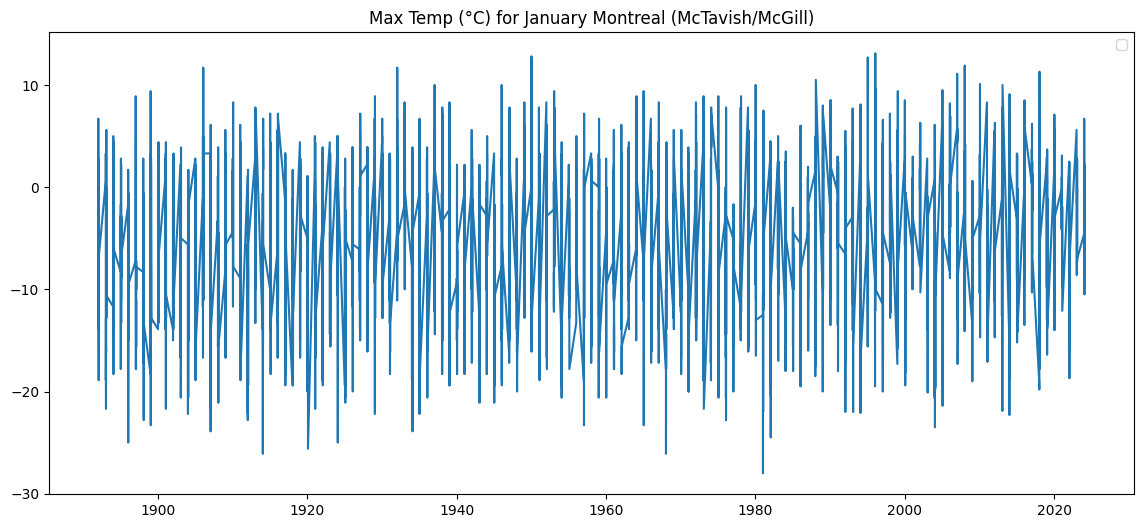

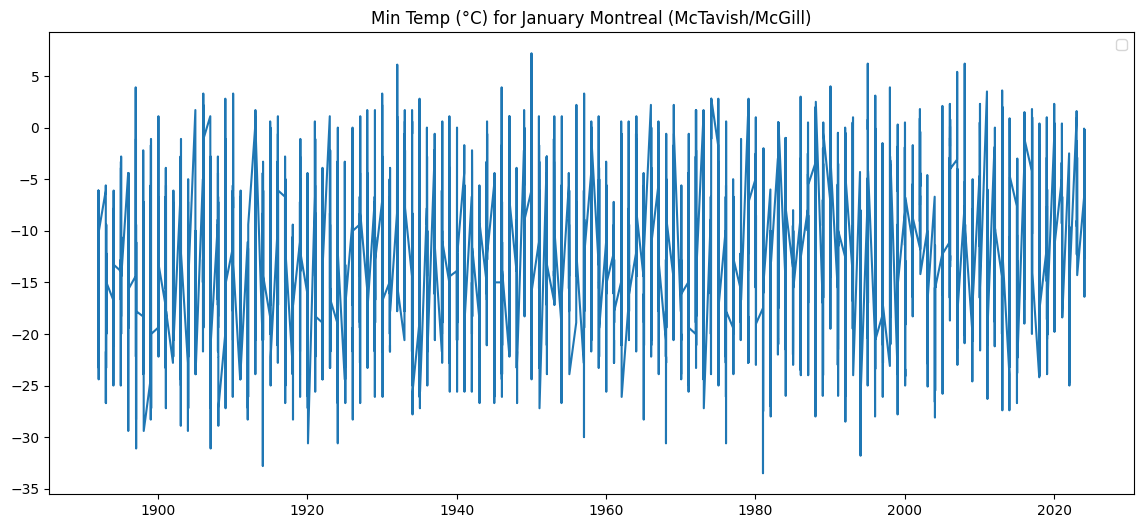

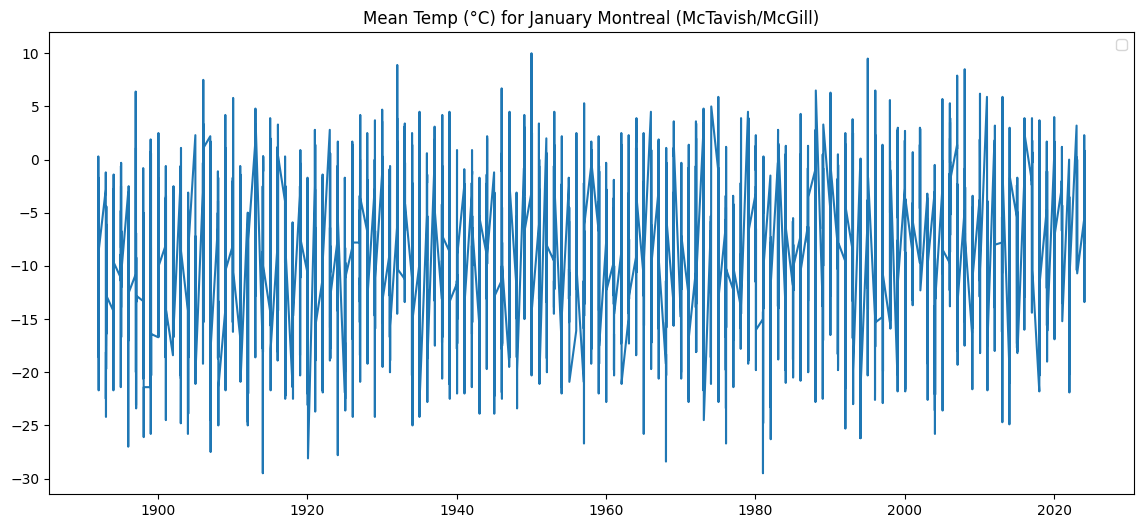

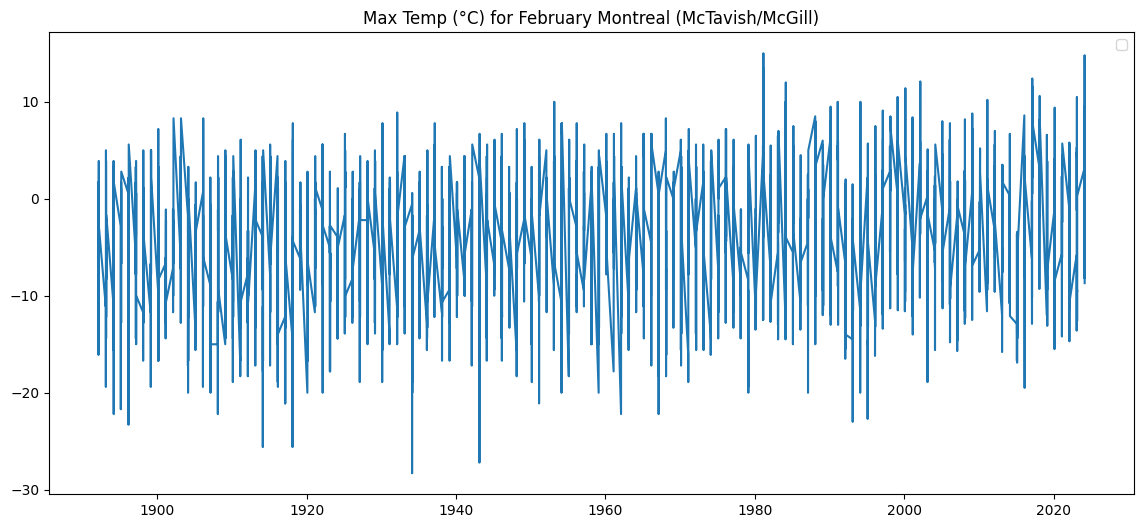

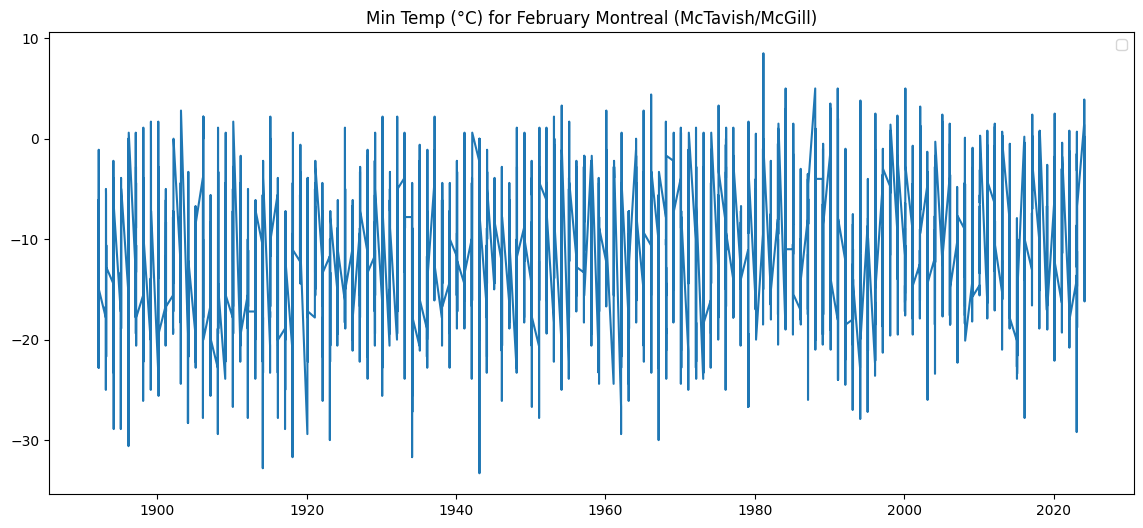

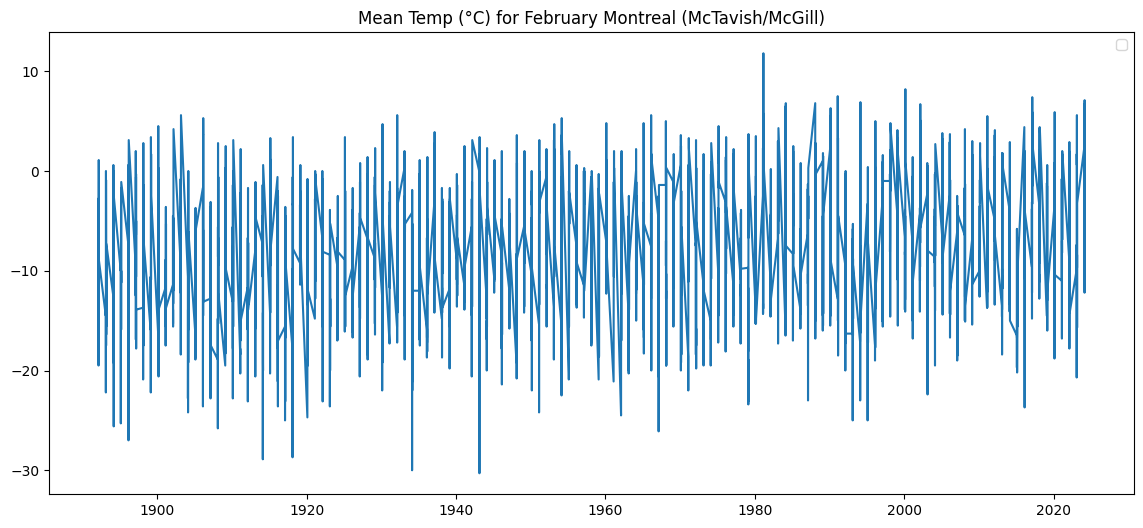

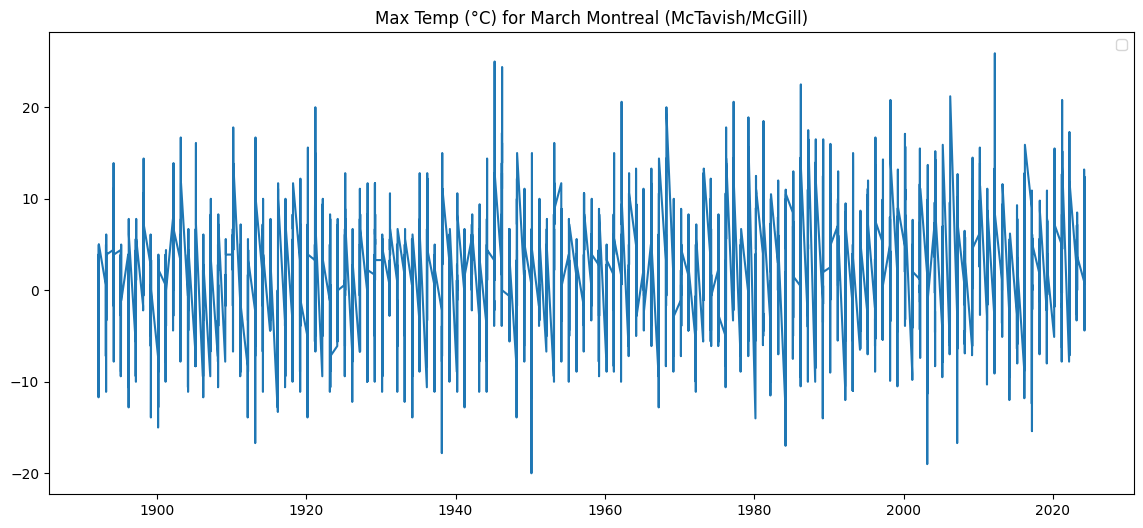

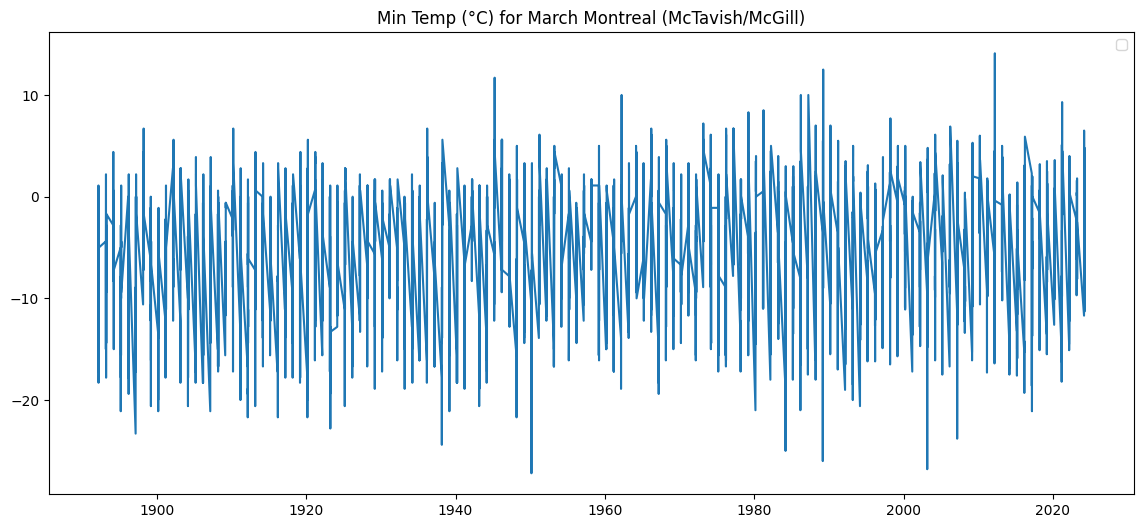

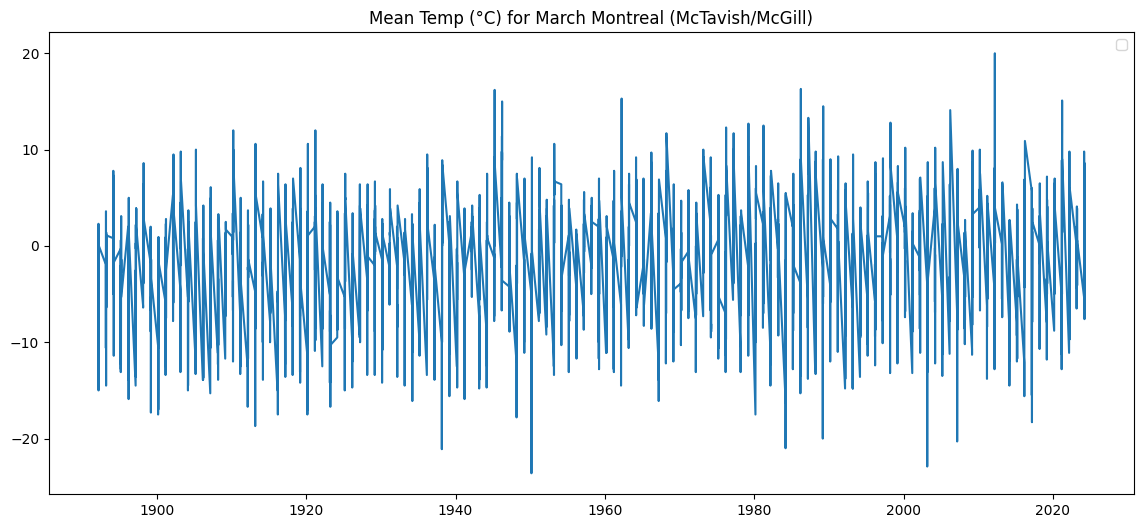

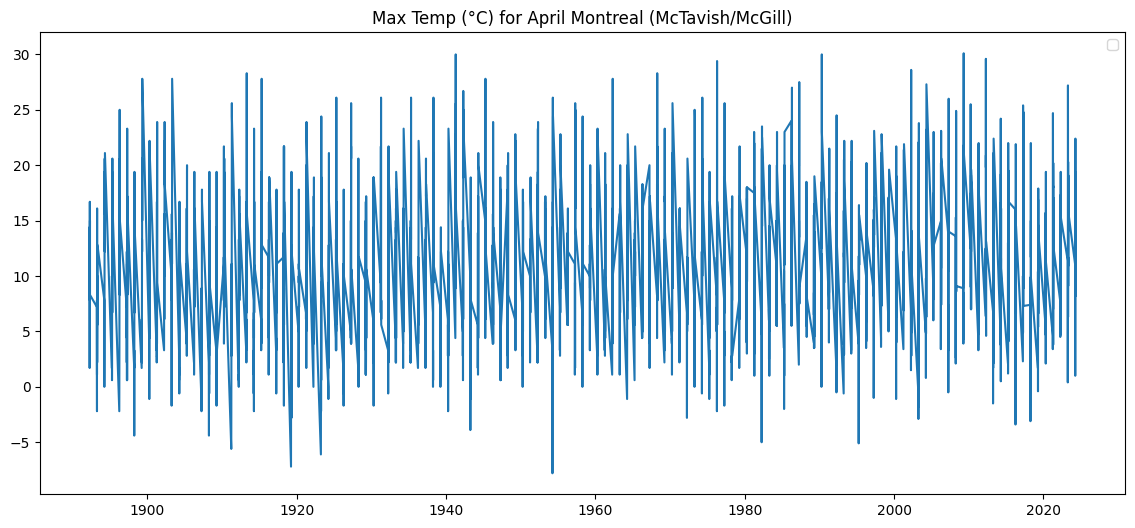

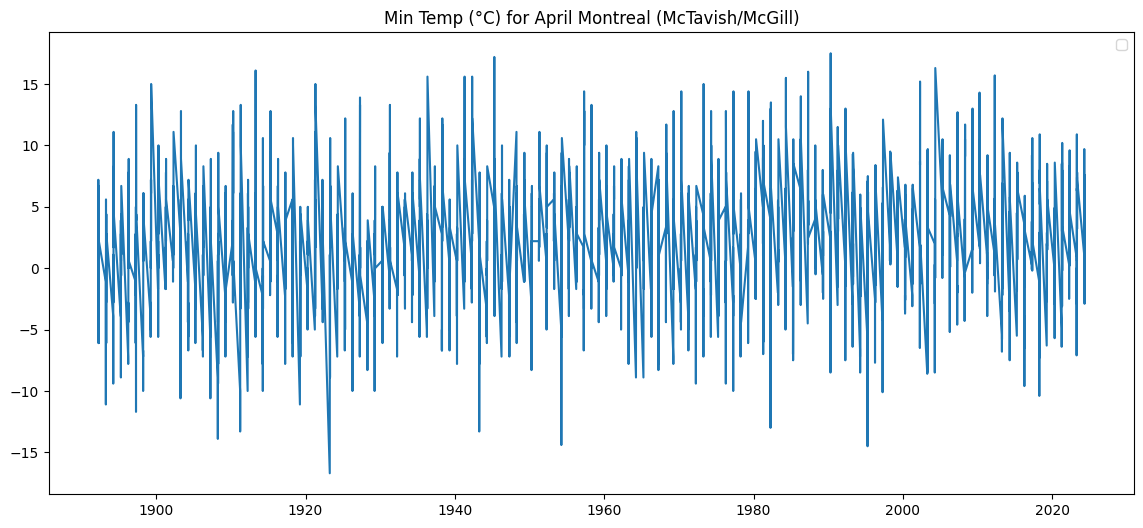

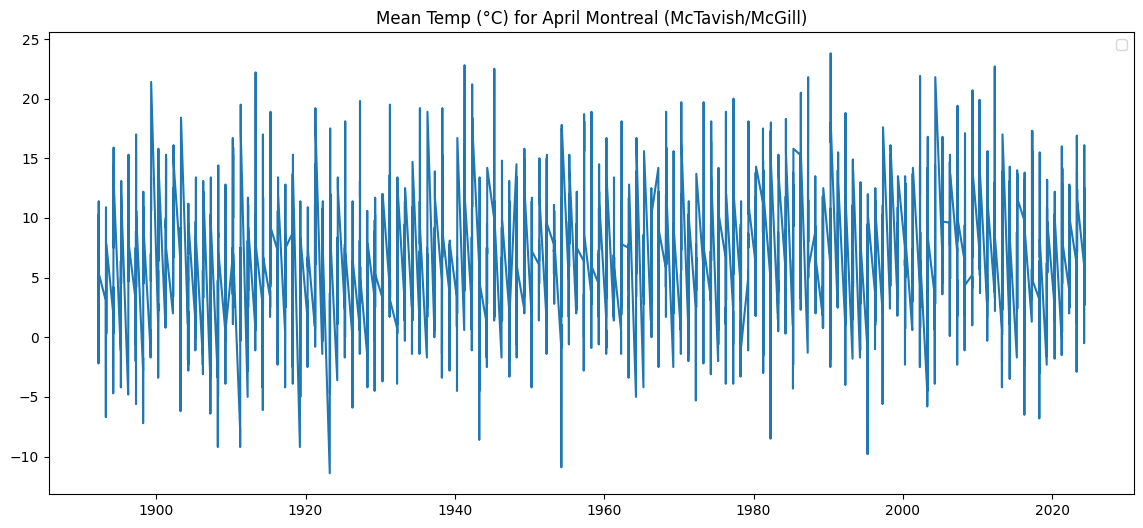

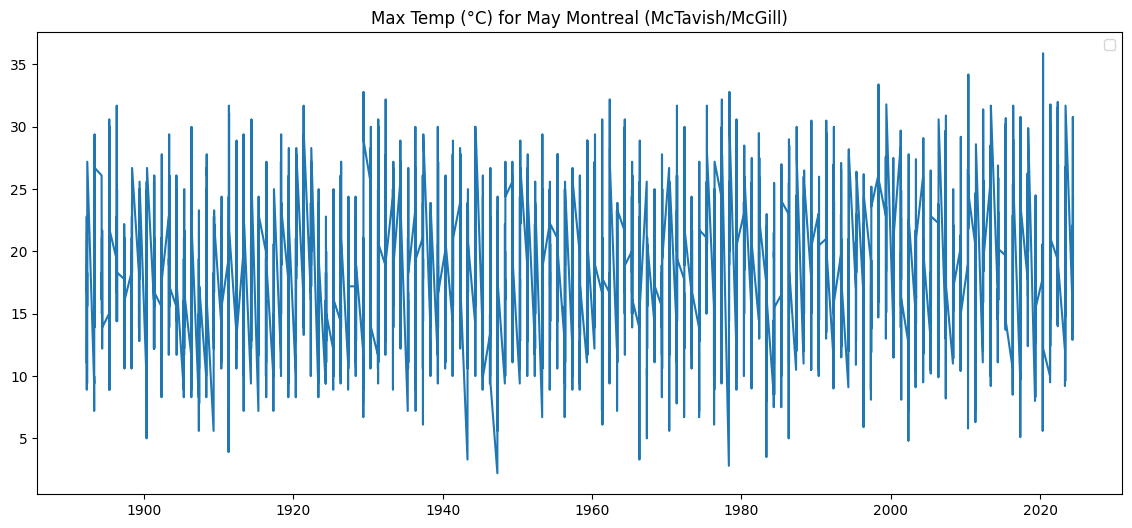

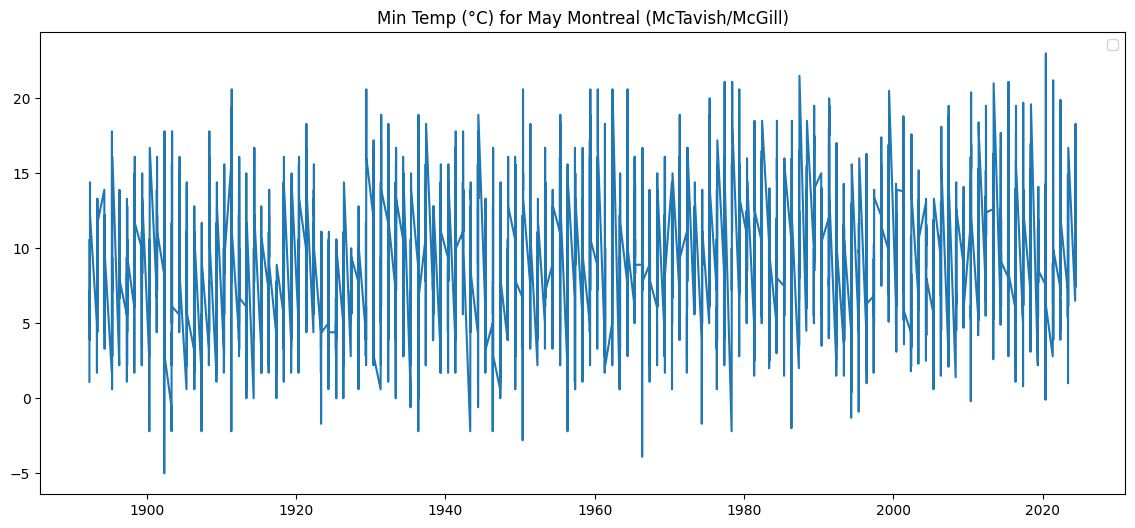

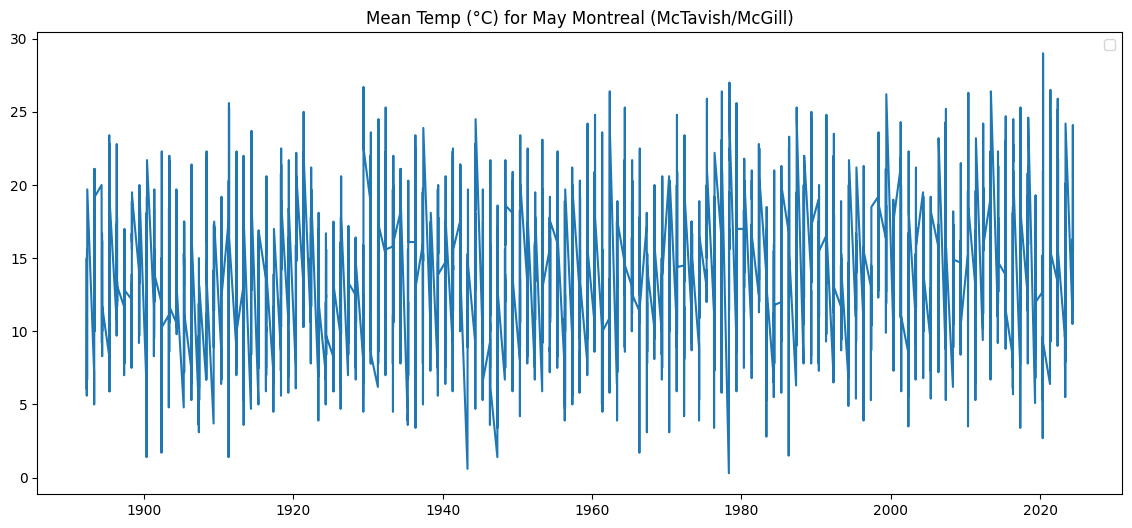

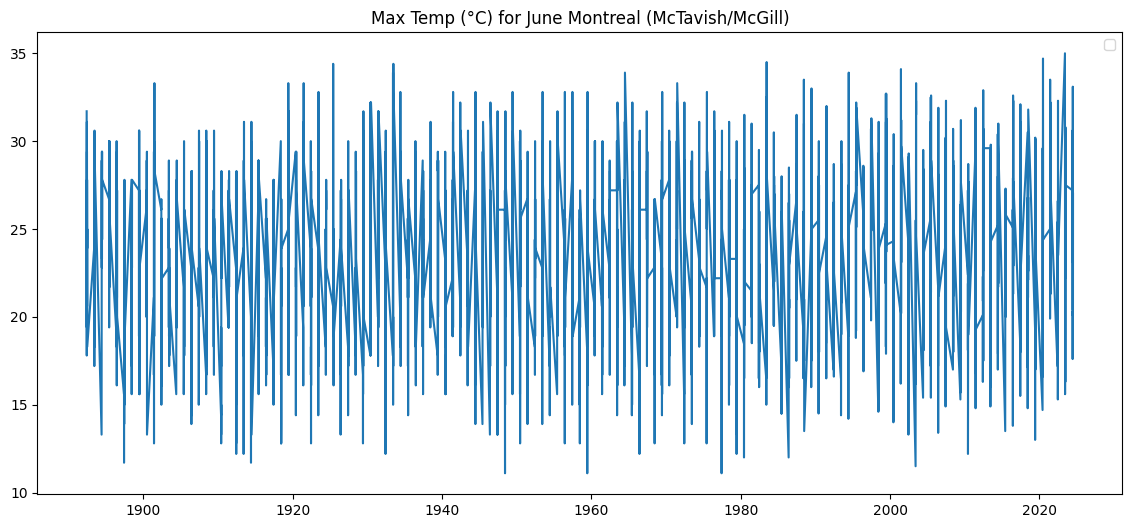

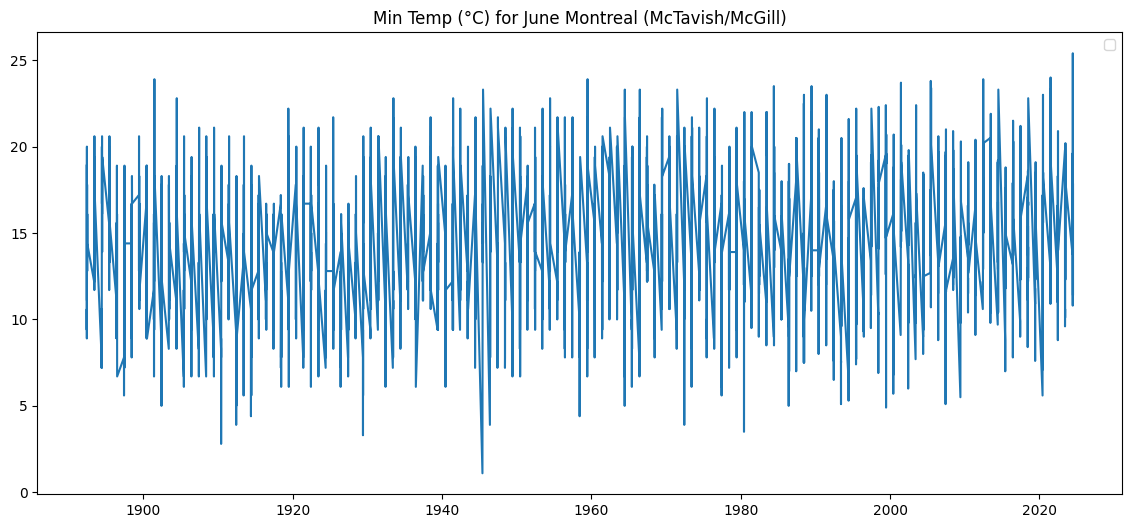

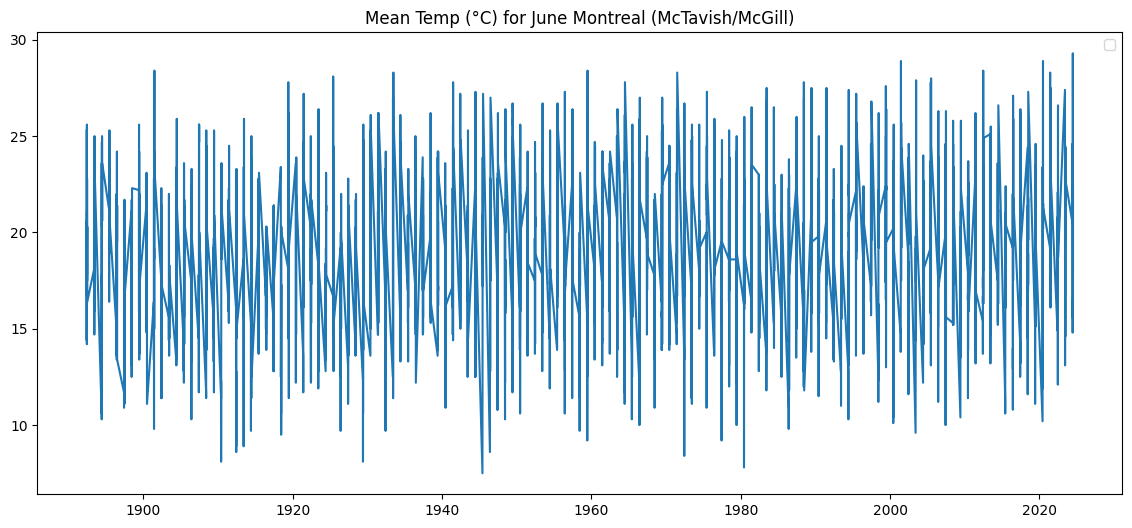

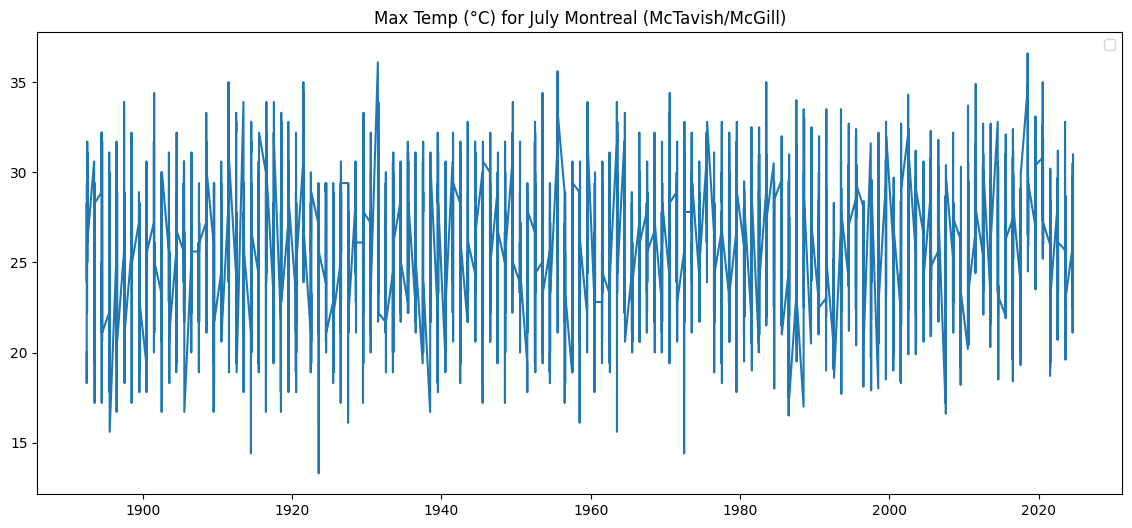

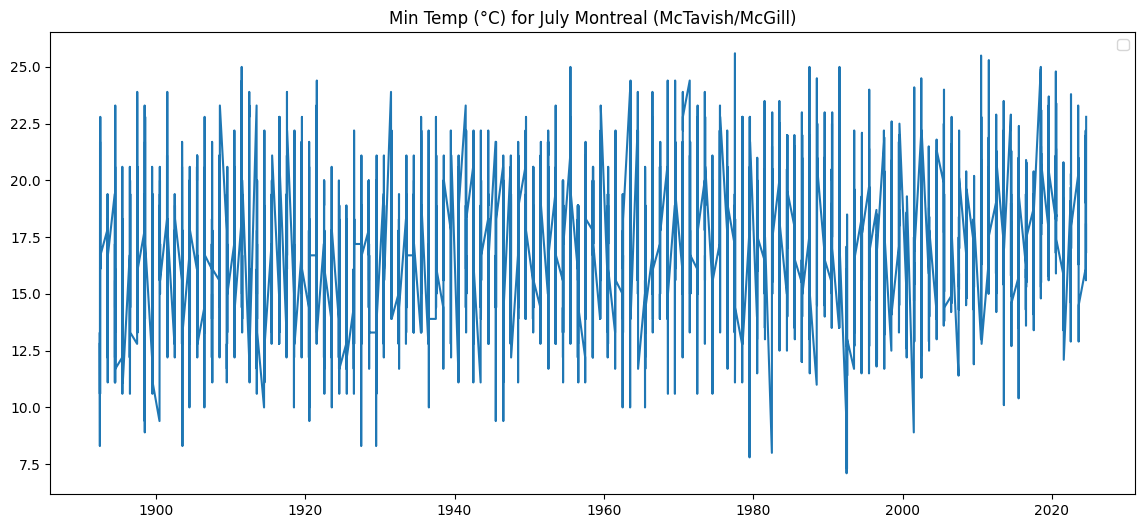

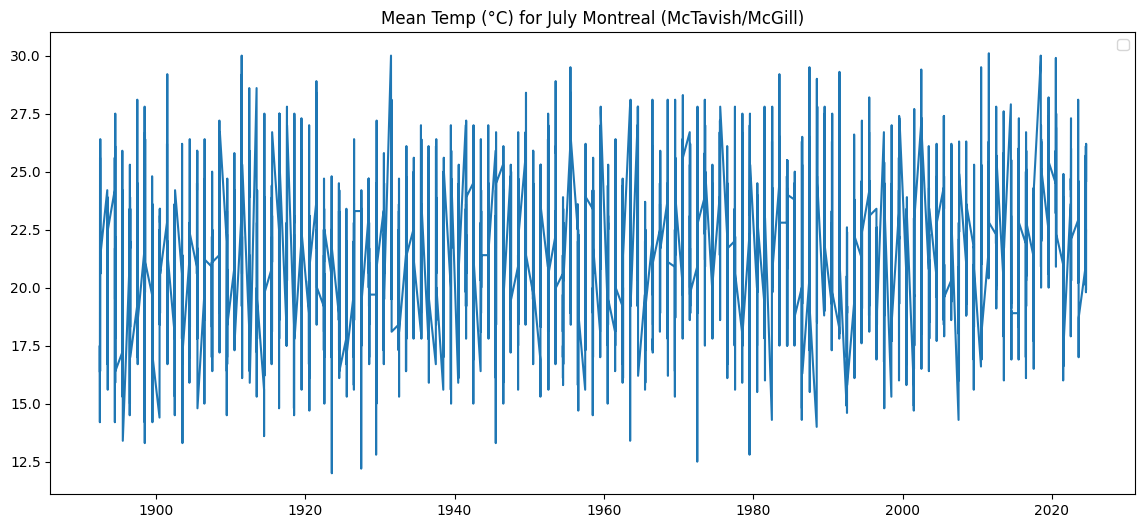

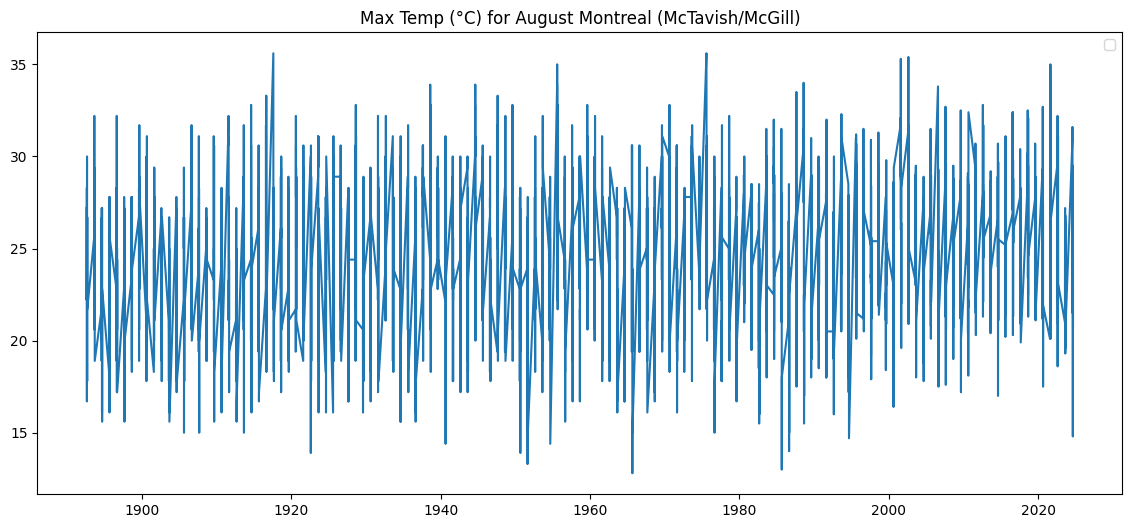

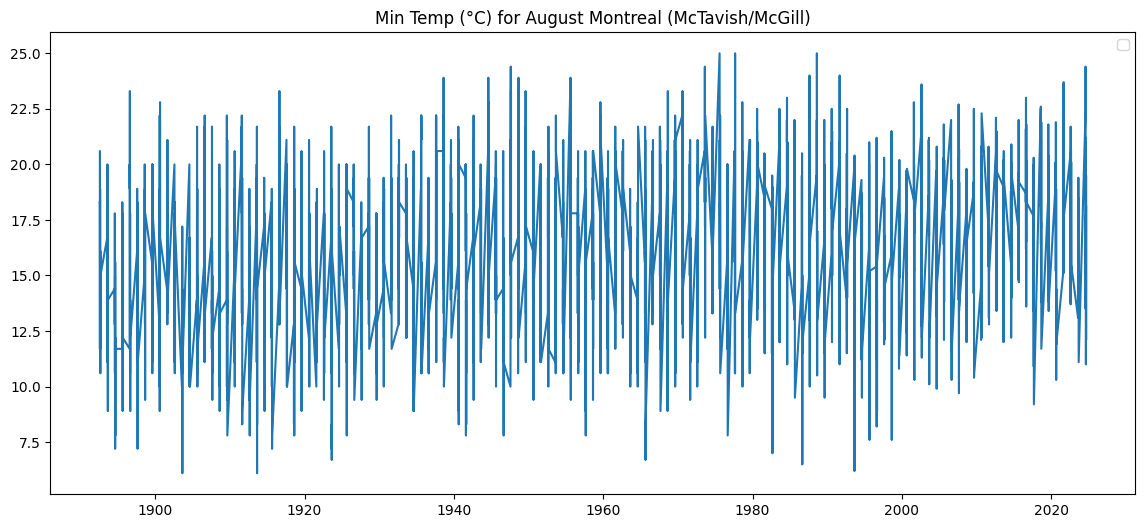

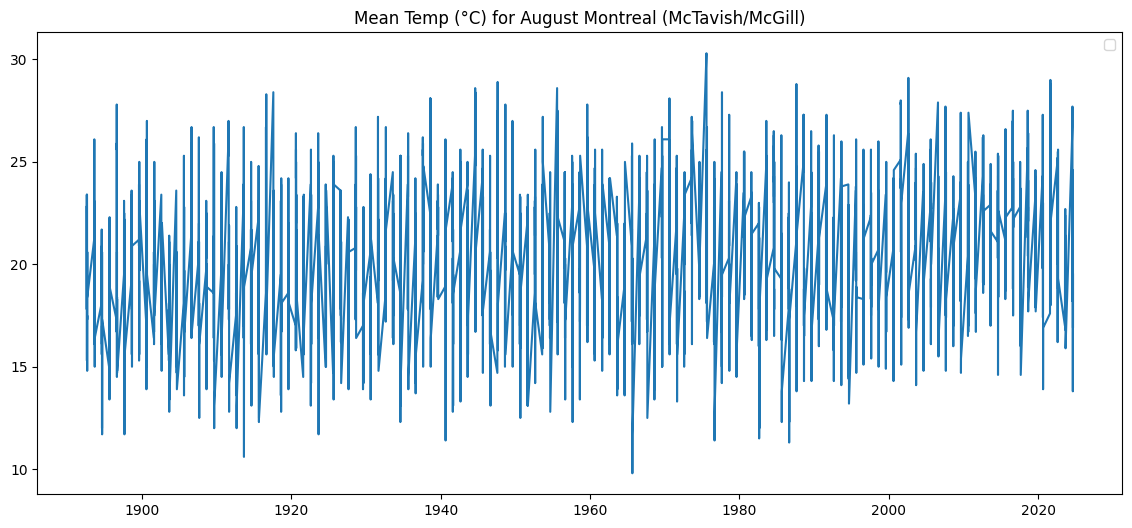

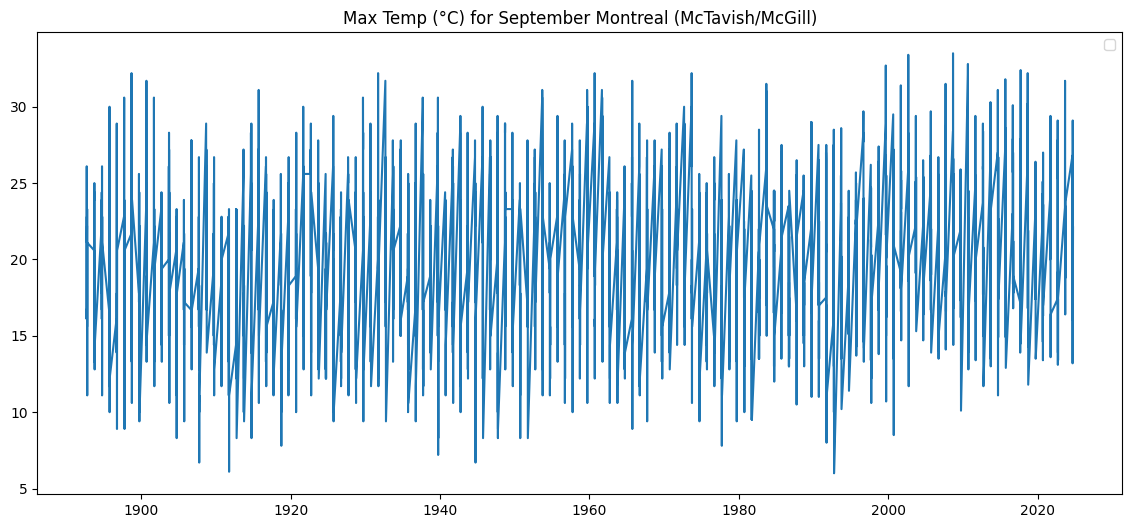

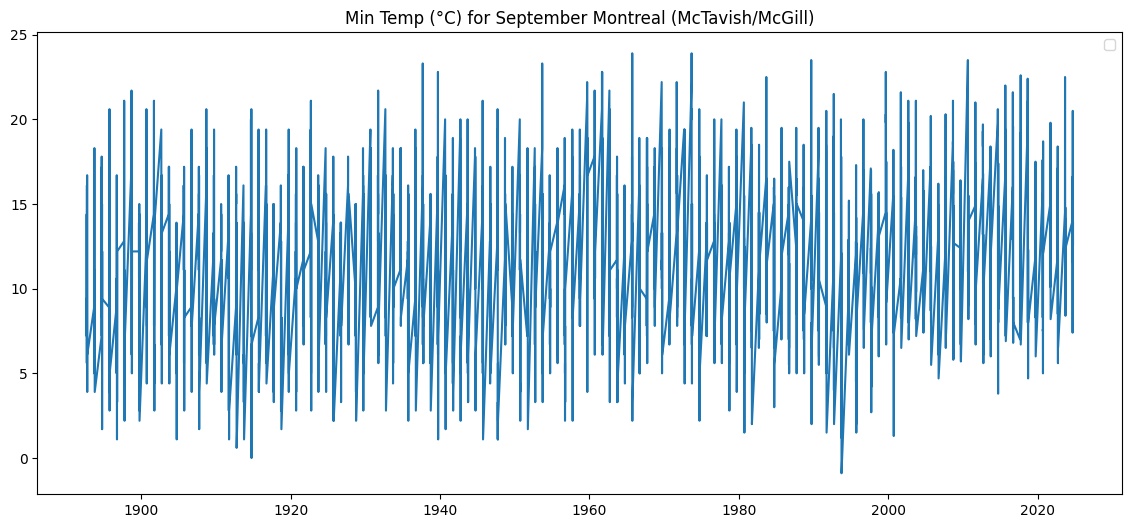

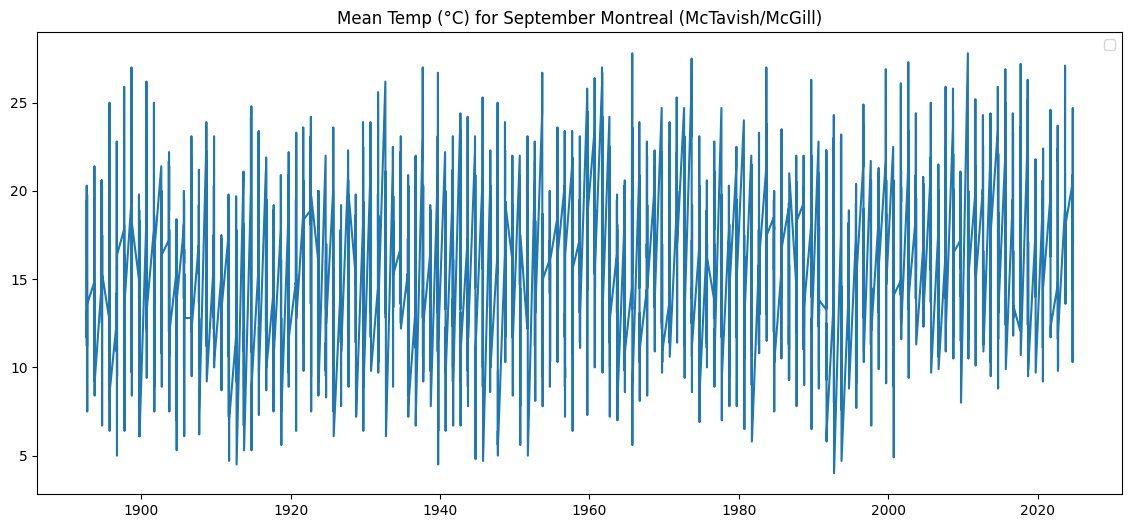

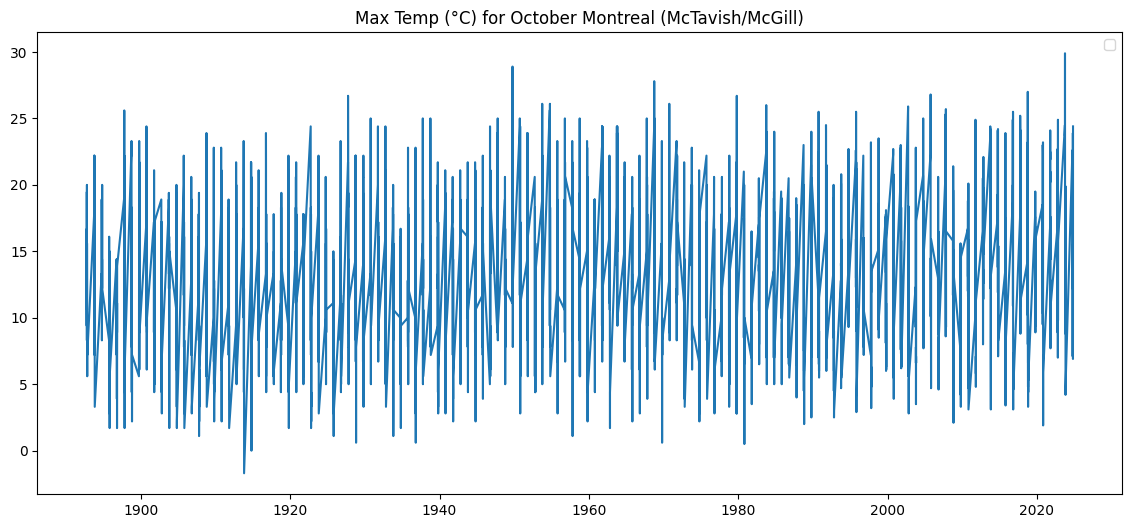

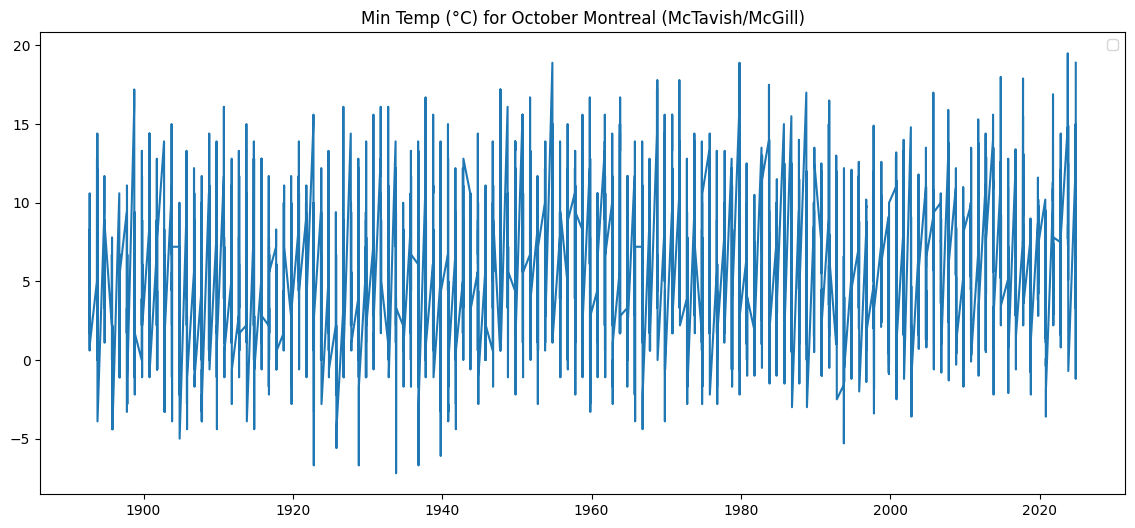

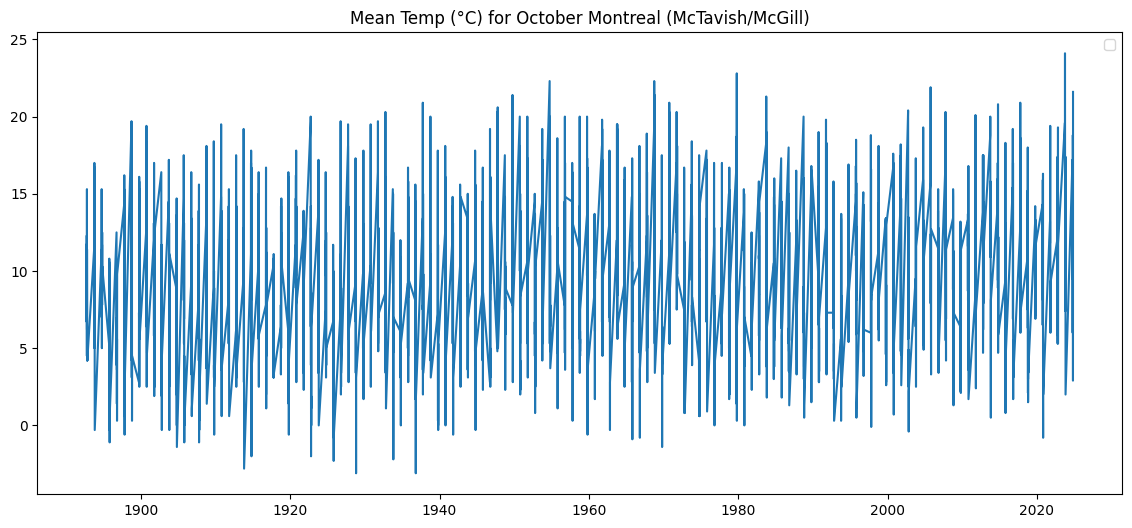

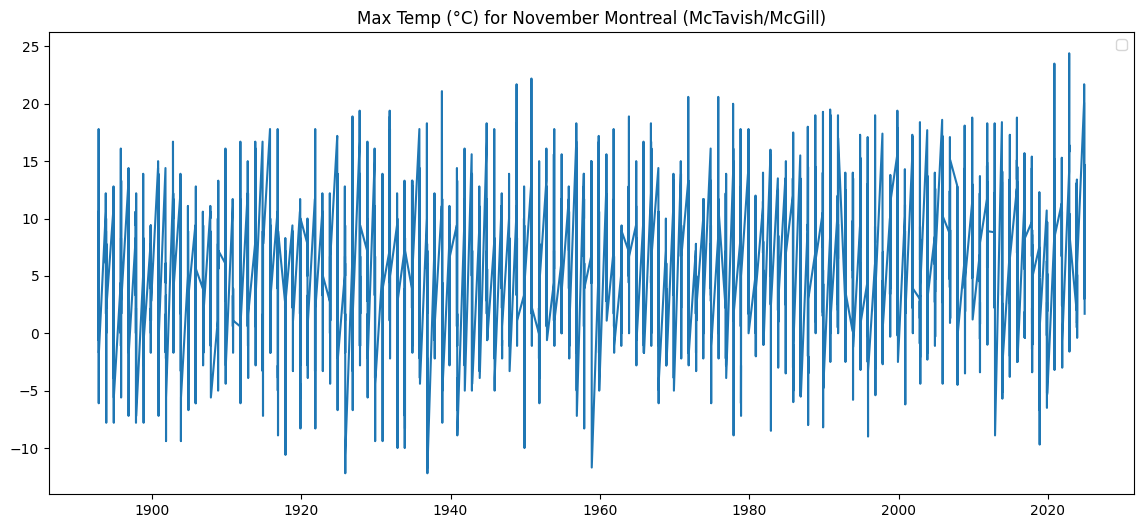

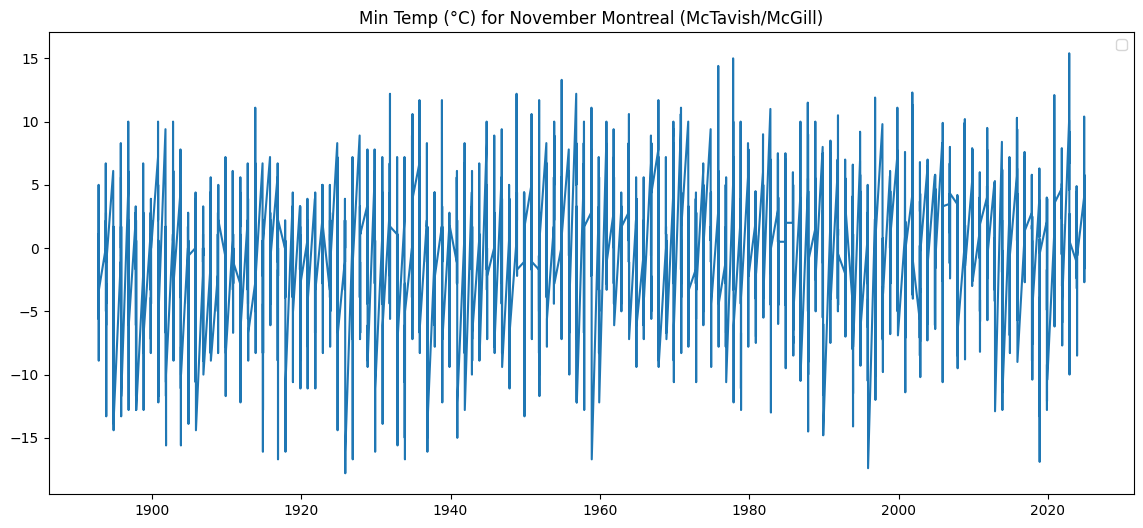

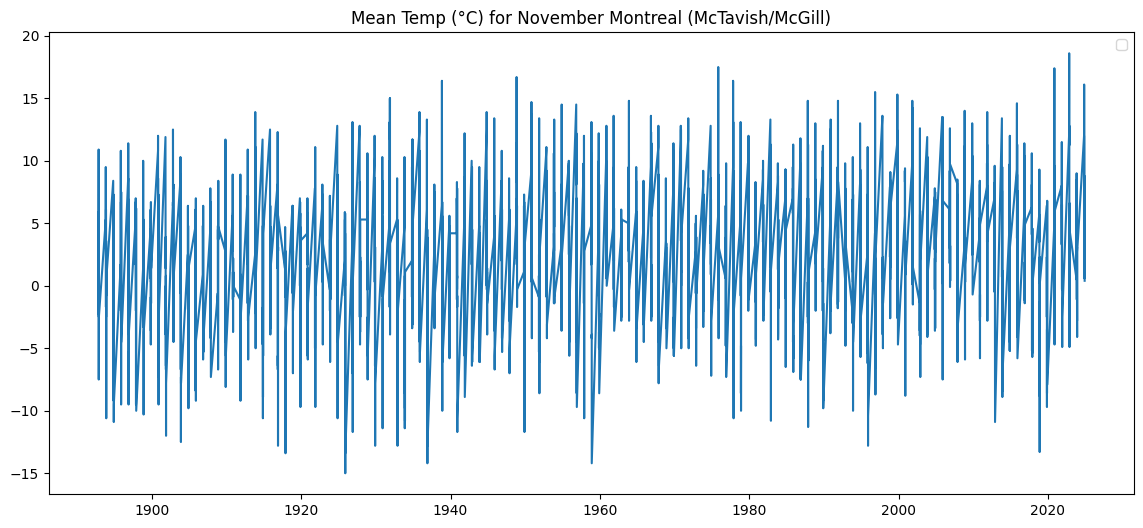

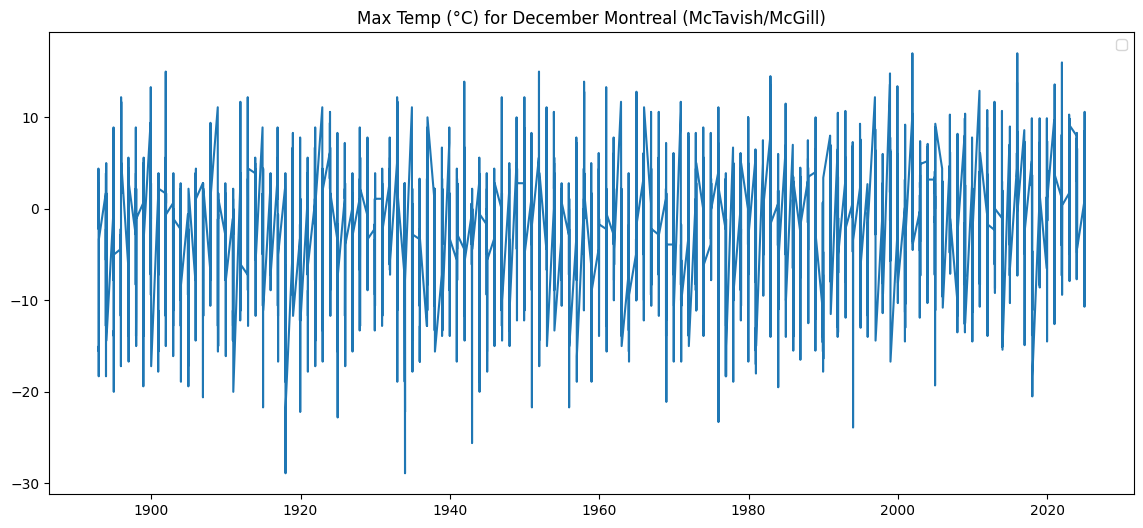

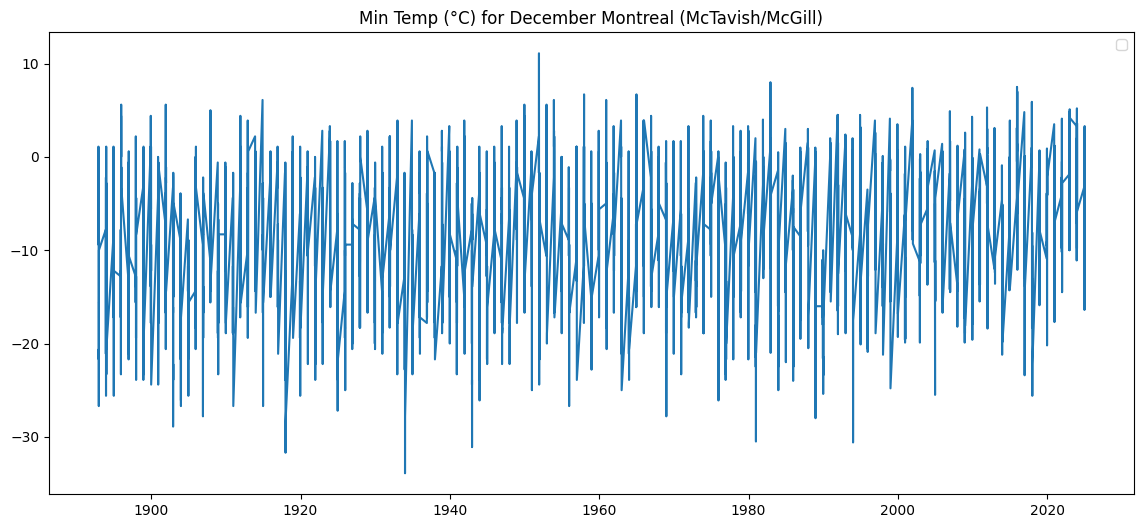

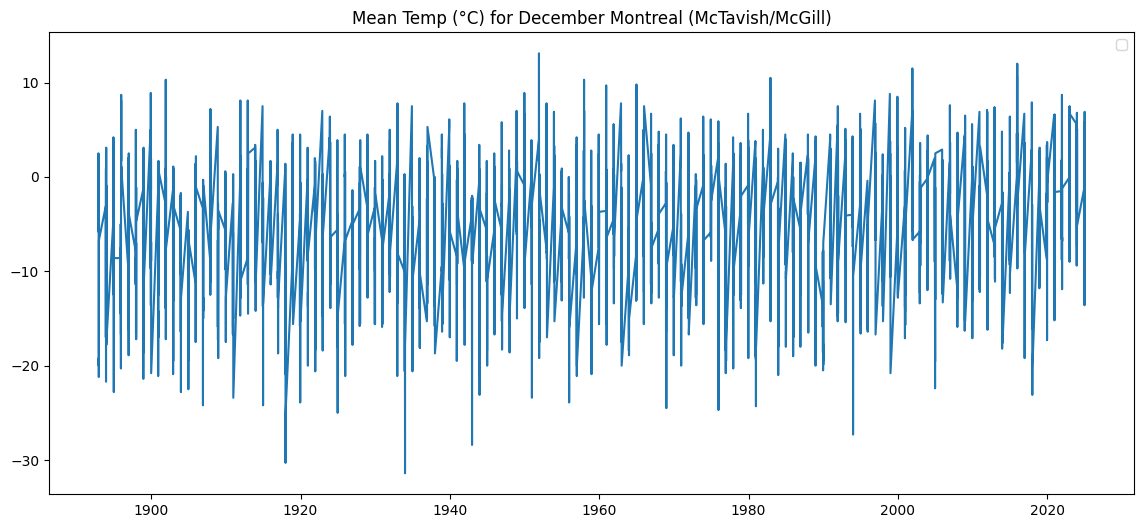

In [14]:
for month in range(1,13):

    month_str = pd.to_datetime(month, format='%m').strftime('%B')

    for T in [Tmax, Tmin, Tmean]:

        tmp = wx_df[wx_df['Month'] == month][T]

        fig = plt.figure(figsize=(14,6))

        ax = plt.plot(tmp.index, tmp)

        plt.title(f'{T} for {month_str} {stn}')

        plt.legend()

        plt.show()

### Put the GreenHouse Gases dataframe and population dataframe on the same frequency as the climate data

In [28]:
if frequency == 'DLY':
    new_range = pd.date_range(start = start_wx, end = end_wx, freq="D")
    print(new_range)
    
    co2_df = co2_df.reindex(new_range)
    co2_df = co2_df.resample('D').interpolate()

    ch4_df = ch4_df.reindex(new_range)
    ch4_df = ch4_df.resample('D').interpolate()

    pop_df = pop_df.reindex(new_range)
    pop_df = pop_df.resample('D').interpolate()
    
elif frequency == 'MLY':
    new_range = pd.date_range(start = start_wx, end = end_wx, freq="ME")
    print(new_range)

    co2_df = co2_df.reindex(new_range)
    co2_df = co2_df.resample('ME').interpolate()

    ch4_df = ch4_df.reindex(new_range)
    ch4_df = ch4_df.resample('ME').interpolate()

    pop_df = pop_df.reindex(new_range)
    pop_df = pop_df.resample('ME').interpolate()
else :
    print('Frequency is NOT monthly or daily')

DatetimeIndex(['1892-01-01', '1892-01-02', '1892-01-03', '1892-01-04',
               '1892-01-05', '1892-01-06', '1892-01-07', '1892-01-08',
               '1892-01-09', '1892-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', length=48578, freq='D')


In [29]:
co2_df

CH4
1892-01-01   859.921329
1892-01-02   859.925885
1892-01-03   859.930442
1892-01-04   859.934998
1892-01-05   859.939554
...                 ...
2024-12-27  1934.802141
2024-12-28  1934.802141
2024-12-29  1934.802141
2024-12-30  1934.802141
2024-12-31  1934.802141

[48578 rows x 1 columns]

In [30]:
ch4_df

CO2
1892-01-01  294.800000
1892-01-02  294.799727
1892-01-03  294.799454
1892-01-04  294.799180
1892-01-05  294.798907
...                ...
2024-12-27  424.610000
2024-12-28  424.610000
2024-12-29  424.610000
2024-12-30  424.610000
2024-12-31  424.610000

[48578 rows x 1 columns]

In [31]:
pop_df

Population
1892-01-01  2.609199e+05
1892-01-02  2.609370e+05
1892-01-03  2.609540e+05
1892-01-04  2.609711e+05
1892-01-05  2.609881e+05
...                  ...
2024-12-27  2.200807e+06
2024-12-28  2.200807e+06
2024-12-29  2.200807e+06
2024-12-30  2.200807e+06
2024-12-31  2.200807e+06

[48578 rows x 1 columns]

### Put all the data into a single dataframe

In [37]:
full_df = pd.concat([co2_df, ch4_df, pop_df, wx_df[[Tmax,Tmin]]], axis=1)
full_df

CH4         CO2    Population  Max Temp (°C)  \
1892-01-01   859.921329  294.800000  2.609199e+05           -5.6   
1892-01-02   859.925885  294.799727  2.609370e+05            6.7   
1892-01-03   859.930442  294.799454  2.609540e+05            2.2   
1892-01-04   859.934998  294.799180  2.609711e+05           -7.2   
1892-01-05   859.939554  294.798907  2.609881e+05          -12.2   
...                 ...         ...           ...            ...   
2024-12-27  1934.802141  424.610000  2.200807e+06           -6.1   
2024-12-28  1934.802141  424.610000  2.200807e+06           -1.7   
2024-12-29  1934.802141  424.610000  2.200807e+06            7.6   
2024-12-30  1934.802141  424.610000  2.200807e+06           10.6   
2024-12-31  1934.802141  424.610000  2.200807e+06            6.3   

            Min Temp (°C)  
1892-01-01          -11.7  
1892-01-02           -6.1  
1892-01-03           -7.8  
1892-01-04          -15.0  
1892-01-05          -16.7  
...                   ...  
2024-12-27          -13.2  
2024-12-28           -9.6  
2024-12-29           -2.6  
2024-12-30            3.3  
2024-12-31            1.6  

[48578 rows x 5 columns]

### Separate Train/Test/Validate dataset

In [42]:
cut_year = 2021

cut = pd.to_datetime(cut_year, format='%Y')

train_df = full_df[full_df.index < cut]
test_df = full_df[full_df.index >= cut]

In [43]:
test_df

CH4         CO2    Population  Max Temp (°C)  \
2021-01-01  1894.800000  416.410000  1.762949e+06           -0.2   
2021-01-02  1894.844164  416.415808  1.763361e+06           -0.6   
2021-01-03  1894.888329  416.421616  1.763773e+06           -0.6   
2021-01-04  1894.932493  416.427425  1.764185e+06           -1.1   
2021-01-05  1894.976658  416.433233  1.764598e+06           -2.5   
...                 ...         ...           ...            ...   
2024-12-27  1934.802141  424.610000  2.200807e+06           -6.1   
2024-12-28  1934.802141  424.610000  2.200807e+06           -1.7   
2024-12-29  1934.802141  424.610000  2.200807e+06            7.6   
2024-12-30  1934.802141  424.610000  2.200807e+06           10.6   
2024-12-31  1934.802141  424.610000  2.200807e+06            6.3   

            Min Temp (°C)  
2021-01-01           -5.1  
2021-01-02           -5.3  
2021-01-03           -3.5  
2021-01-04           -3.4  
2021-01-05           -3.6  
...                   ...  
2024-12-27          -13.2  
2024-12-28           -9.6  
2024-12-29           -2.6  
2024-12-30            3.3  
2024-12-31            1.6  

[1461 rows x 5 columns]

In [44]:
train_df

CH4         CO2    Population  Max Temp (°C)  \
1892-01-01   859.921329  294.800000  2.609199e+05           -5.6   
1892-01-02   859.925885  294.799727  2.609370e+05            6.7   
1892-01-03   859.930442  294.799454  2.609540e+05            2.2   
1892-01-04   859.934998  294.799180  2.609711e+05           -7.2   
1892-01-05   859.939554  294.798907  2.609881e+05          -12.2   
...                 ...         ...           ...            ...   
2020-12-27  1894.580328  416.379945  1.761731e+06           -2.7   
2020-12-28  1894.624262  416.385956  1.761975e+06            4.7   
2020-12-29  1894.668197  416.391967  1.762218e+06           -2.2   
2020-12-30  1894.712131  416.397978  1.762462e+06            0.8   
2020-12-31  1894.756066  416.403989  1.762705e+06            3.7   

            Min Temp (°C)  
1892-01-01          -11.7  
1892-01-02           -6.1  
1892-01-03           -7.8  
1892-01-04          -15.0  
1892-01-05          -16.7  
...                   ...  
2020-12-27           -8.7  
2020-12-28           -2.7  
2020-12-29           -8.8  
2020-12-30           -7.3  
2020-12-31           -6.9  

[47117 rows x 5 columns]

### Separate RNN input and output data

In [47]:
cols_in = ['CH4', 'CO2', 'Population']
cols_out = [Tmax, Tmin]

X_train = train_df[cols_in]
X_test = test_df[cols_in]

Y_train = train_df[cols_out]
Y_test = test_df[cols_out]

### Scale the dataset

In [50]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled_train = scaler_x.fit_transform(X_train)
X_scaled_test = scaler_x.transform(X_test)

Y_scaled_train = scaler_y.fit_transform(Y_train)
Y_scaled_test = scaler_y.transform(Y_test)

### TimeSeries Generator

In [52]:
n_input = 31

ts_generator = TimeseriesGenerator(X_scaled_train, 
                                   Y_scaled_train,
                                   length=n_input,
                                   batch_size=32)

ts_generator[0]

(array([[[0.00000000e+00, 8.21665754e-04, 0.00000000e+00],
         [4.40288378e-06, 8.19420766e-04, 1.13552697e-05],
         [8.80576755e-06, 8.17175778e-04, 2.27105395e-05],
         ...,
         [1.23280746e-04, 7.58806079e-04, 3.17947553e-04],
         [1.27683629e-04, 7.56561091e-04, 3.29302823e-04],
         [1.32086513e-04, 7.54316102e-04, 3.40658092e-04]],
 
        [[4.40288378e-06, 8.19420766e-04, 1.13552697e-05],
         [8.80576755e-06, 8.17175778e-04, 2.27105395e-05],
         [1.32086513e-05, 8.14930789e-04, 3.40658092e-05],
         ...,
         [1.27683629e-04, 7.56561091e-04, 3.29302823e-04],
         [1.32086513e-04, 7.54316102e-04, 3.40658092e-04],
         [1.36489397e-04, 7.52071114e-04, 3.52013362e-04]],
 
        [[8.80576755e-06, 8.17175778e-04, 2.27105395e-05],
         [1.32086513e-05, 8.14930789e-04, 3.40658092e-05],
         [1.76115351e-05, 8.12685801e-04, 4.54210790e-05],
         ...,
         [1.32086513e-04, 7.54316102e-04, 3.40658092e-04],
        

### Build RNN model

In [58]:
print(X_scaled_train.shape[0], X_scaled_train.shape[1])
print(Y_scaled_train.shape[1])

47117 3
2


In [54]:
rnn = Sequential()

rnn.add(LSTM(256, activation='relu', input_shape=((X_scaled_train.shape[0], X_scaled_train.shape[1]))))

rnn.add(Dense(Y_scaled_train.shape[1]))

rnn.compile(optimizer='adam', loss='mse')

2025-04-03 13:01:52.695116: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/abf/Dev/climate-proj/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [59]:
rnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       266,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,754 (1.02 MB)

 Trainable params: 266,754 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
rnn.fit(ts_generator, epochs=100)

Epoch 1/100


/home/abf/Dev/climate-proj/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1472/1472 ━━━━━━━━━━━━━━━━━━━━ 157s 105ms/step - loss: 0.4292
Epoch 2/100
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 154s 105ms/step - loss: 0.0391
Epoch 3/100
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 146s 99ms/step - loss: 0.0381 
Epoch 4/100
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 232s 120ms/step - loss: 0.0396
Epoch 5/100
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 154s 105ms/step - loss: 0.0396
Epoch 6/100
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 159s 108ms/step - loss: 0.0390
Epoch 7/100
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 156s 106ms/step - loss: 0.0390
Epoch 8/100
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 178s 121ms/step - loss: 0.0377
Epoch 9/100
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 151s 103ms/step - loss: 0.0384
Epoch 10/100
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 153s 104ms/step - loss: 0.0395
Epoch 11/100
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 148s 100ms/step - loss: 0.0381
Epoch 12/100
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 148s 100ms/step - loss: 0.0369
Epoch 13/100
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 149s 101ms/step - loss: 0.0374
Epoch 14/100
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 15

### Save model and scalers

In [ ]:
rnn.save(os.path.join(model_dir, 'rnn_firsttrial.keras'))

In [ ]:
joblib.dump(scaler_x, os.path.join(model_dir, 'scaler_x.joblib'))
joblib.dump(scaler_y, os.path.join(model_dir, 'scaler_y.joblib'))

### Evaluate the model on the testing dataset

In [ ]:
rnn_prediction_test = []

len_ = 365

current_data = X_scaled_test[-len_:].reshape((1, len_, X_scaled_test.shape[1]))

#len_ = X_scaled_test.shape[0]

for i in range(len_): 
    
    # This is our prediction for 1 timestep into the future
    current_prediction = rnn.predict(X_scaled_test)[0]
    
    # Append it to our list of prediction
    rnn_prediction_test.append(current_prediction)
    
    current_data = np.append(current_data[:,1:,:],[[current_prediction]],axis=1)

rnn_prediction_test

### Inversing prediction

In [ ]:
inversed_preds_test = scaler_y.inverse_transform(rnn_prediction_test)

cols_out_new = (pd.Series(cols_out) + 'model').tolist()

pred_test_df = pd.DataFrame(inversed_preds_test, columns=cols_out_new)

pred_test_df.index = test_data.iloc[-len_:]

full_pred_test_df = pd.concat([test_data.iloc[-len_:],pred_test_df]], axis=1)

full_pred_test_df

### Evaluating model's prediction accuracy

In [ ]:
print(f"Test RMSE: {np.sqrt(mean_squared_error(full_pred_test_df[Tmax],full_pred_test_df[cols_out_new[0]])}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(full_pred_test_df[Tmin],full_pred_test_df[cols_out_new[1]]))}")

In [ ]:
full_pred_test_df.plot(figsize=(12,4))

In [33]:
full_df.isna().sum()

CH4                              0
CO2                              0
Population                       0
Station                          0
Longitude (x)                    0
Latitude (y)                     0
Station Name                     0
Climate ID                       0
Year                             0
Month                            0
Day                              0
Data Quality                 48578
Max Temp (°C)                    0
Max Temp Flag                48493
Min Temp (°C)                    0
Min Temp Flag                48412
Mean Temp (°C)                   0
Mean Temp Flag               48485
Heat Deg Days (°C)               0
Heat Deg Days Flag           48485
Cool Deg Days (°C)               0
Cool Deg Days Flag           48485
Total Rain (mm)              10463
Total Rain Flag              37565
Total Snow (cm)              10471
Total Snow Flag              37897
Total Precip (mm)              481
Total Precip Flag            43485
Snow on Grnd (cm)   

In [15]:
tmp = wx_df.groupby(['Year']).count()

tmp[tmp['Station'] < 365]

Empty DataFrame
Columns: [Station, Longitude (x), Latitude (y), Station Name, Climate ID, Month, Day, Data Quality, Max Temp (°C), Max Temp Flag, Min Temp (°C), Min Temp Flag, Mean Temp (°C), Mean Temp Flag, Heat Deg Days (°C), Heat Deg Days Flag, Cool Deg Days (°C), Cool Deg Days Flag, Total Rain (mm), Total Rain Flag, Total Snow (cm), Total Snow Flag, Total Precip (mm), Total Precip Flag, Snow on Grnd (cm), Snow on Grnd Flag, Dir of Max Gust (10s deg), Dir of Max Gust Flag, Spd of Max Gust (km/h), Spd of Max Gust Flag]
Index: []

[0 rows x 30 columns]